2024-12-30 11:34:31.368726: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-30 11:34:31.641390: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-30 11:34:31.974547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735547672.172806   14469 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735547672.326988   14469 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-30 11:34:32.821417: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Epoch 1/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - loss: 63.8973 - mae: 5.8994 - mse: 63.8973 - val_loss: 5.3391 - val_mae: 2.0105 - val_mse: 5.3391 - learning_rate: 0.0010
Epoch 2/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 7.0091 - mae: 2.2076 - mse: 7.0091 - val_loss: 5.3538 - val_mae: 2.0129 - val_mse: 5.3538 - learning_rate: 0.0010
Epoch 3/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 6.7618 - mae: 2.1787 - mse: 6.7618 - val_loss: 5.3114 - val_mae: 2.0124 - val_mse: 5.3114 - learning_rate: 0.0010
Epoch 4/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 6.5565 - mae: 2.1503 - mse: 6.5565 - val_loss: 5.3708 - val_mae: 2.0129 - val_mse: 5.3708 - learning_rate: 0.0010
Epoch 5/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 6.3758 - mae: 2.1283 - mse: 6.3758 - val_loss: 5.3113 - val_mae: 2.0126 - val_mse: 5.3113 - learning_rate: 0.0010
Epoch 6/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 6.2436 - mae: 2.1132 - mse: 6.2436 - val_loss: 5.3

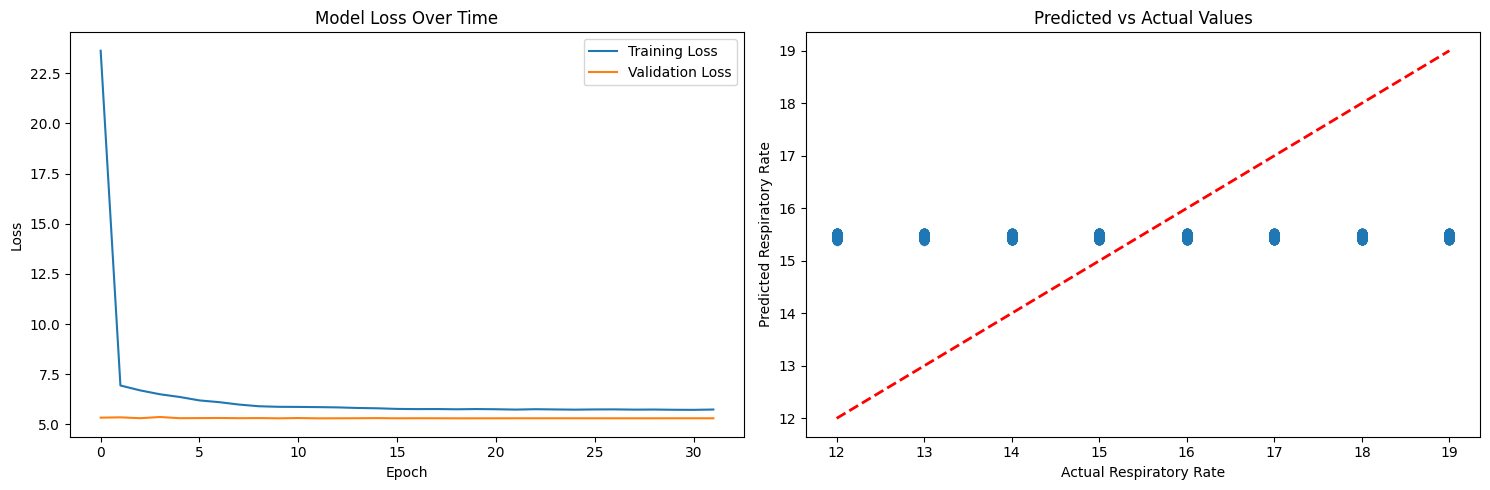

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare data
df = pd.read_csv('./data/human_vital_signs_dataset_2024.csv')

# Drop non-numeric columns
columns_to_drop = ['Patient ID', 'Timestamp', 'Gender', 'Body Temperature', 'Derived_MAP', 'Risk Category']
df = df.drop(columns=columns_to_drop, errors='ignore')

# Convert categorical columns to numeric using one-hot encoding
df = pd.get_dummies(df, drop_first=True)

# Define Features and Target (using all relevant features)
# Assuming Respiratory Rate is the target
X = df.drop(columns=['Respiratory Rate'], errors='ignore')
y = df['Respiratory Rate']

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Enhanced model architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='mse',
              metrics=['mae', 'mse'])

# Callbacks for better training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

# Train model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate model
y_pred = model.predict(X_test_scaled).flatten()

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print("\nModel Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Visualization of results
plt.figure(figsize=(15, 5))

# Training history
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Predicted vs Actual
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Respiratory Rate')
plt.ylabel('Predicted Respiratory Rate')
plt.title('Predicted vs Actual Values')

plt.tight_layout()
plt.show()

Error: name 'scaler' is not defined. Make sure the input length matches the training data feature count.
Error: name 'scaler' is not defined


NameError: name 'model' is not defined